In [1]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
from tqdm import tqdm as status_loading
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
list_of_images = []
list_of_labels = []
for root, dirs, files in os.walk('../../full_data_sorted'):
    for file in files:
        if file.endswith('250.0_dims_3_barcode.png'):
            list_of_images.append(os.path.join(root, file))
            list_of_labels.append(os.path.join(root, file).split(os.sep)[-3])

In [3]:
le = LabelEncoder()
list_of_labels = le.fit_transform(list_of_labels)

In [4]:
X_trainval, X_test, y_trainval, y_test = train_test_split(list_of_images, list_of_labels, test_size=0.2, random_state=2)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=2)

In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.labels = labels
        self.images = images
        self.transform = transform
        self.read_images()
        
    def __getitem__(self, idx):
        img = self.readed_images[idx]
        lbl = torch.tensor(self.labels[idx], dtype=int)
        if self.transform is not None:
            img = self.transform(img)
        return img, lbl
    
    def __len__(self):
        return len(self.labels)
    
    def read_images(self):
        readed_images = []
        for file in status_loading(self.images):
            img = Image.open(file).convert('RGB')
            readed_images.append(img)
        self.readed_images = readed_images

In [6]:
transforming = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [7]:
train_dataset = CustomImageDataset(X_train, y_train, transform=transforming)
val_dataset = CustomImageDataset(X_val, y_val, transform=transforming)
test_dataset = CustomImageDataset(X_test, y_test, transform=transforming)

100%|██████████| 31/31 [00:13<00:00,  2.25it/s]


In [8]:
target_list = []

for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)

In [9]:
def get_class_distribution(obj):
    count_dict = {
        'rating_1': 0,
        'rating_2': 0,
        'rating_3': 0,
        'rating_4': 0,
        'rating_5': 0,
    }
    
    for i in obj:
        if i == 0:
            count_dict['rating_1'] += 1
        elif i == 1:
            count_dict['rating_2'] += 1
        elif i == 2:
            count_dict['rating_3'] += 1
        elif i == 3:
            count_dict['rating_4'] += 1
        elif i == 4:
            count_dict['rating_5'] += 1
        else:
            print('Check classes')
            
    return count_dict

In [10]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float)

print(class_weights)

tensor([0.0526, 0.0385, 0.0400, 0.0500, 0.1667])


In [11]:
class_weights_all = class_weights[target_list]
class_weights_all

tensor([0.0385, 0.0385, 0.0526, 0.0400, 0.0385, 0.0400, 0.0526, 0.0385, 0.0500,
        0.0400, 0.0526, 0.0500, 0.0385, 0.0400, 0.0385, 0.0500, 0.1667, 0.0500,
        0.0526, 0.0400, 0.0385, 0.0385, 0.0400, 0.0400, 0.1667, 0.0526, 0.1667,
        0.0400, 0.0526, 0.0526, 0.0385, 0.0400, 0.0385, 0.0526, 0.0500, 0.0400,
        0.0385, 0.0526, 0.0400, 0.0500, 0.0500, 0.0400, 0.1667, 0.0385, 0.0400,
        0.1667, 0.0385, 0.0500, 0.0400, 0.0400, 0.0526, 0.0526, 0.0400, 0.0400,
        0.0526, 0.0385, 0.0400, 0.0400, 0.0385, 0.0500, 0.0500, 0.0400, 0.0500,
        0.0400, 0.0385, 0.0526, 0.0385, 0.0500, 0.0385, 0.0385, 0.0500, 0.0500,
        0.0500, 0.0385, 0.0526, 0.0526, 0.0526, 0.0385, 0.0400, 0.0400, 0.0400,
        0.0385, 0.0500, 0.0385, 0.0385, 0.0400, 0.0500, 0.1667, 0.0526, 0.0385,
        0.0526, 0.0500, 0.0500, 0.0526, 0.0385, 0.0500])

In [12]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [13]:
BATCH_SIZE = 16
EPOCHS = 200
LEARNING_RATE = 1e-5
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [14]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=weighted_sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=1)

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.block1 = self.conv_block(c_in=3, c_out=512, dropout=0.2, kernel_size=5, stride=1, padding=2)
        self.block2 = self.conv_block(c_in=512, c_out=256, dropout=0.2, kernel_size=3, stride=1, padding=1)
        self.block3 = self.conv_block(c_in=256, c_out=128, dropout=0.2, kernel_size=3, stride=1, padding=1)
        self.block4 = self.conv_block(c_in=128, c_out=64, dropout=0.2, kernel_size=3, stride=1, padding=1)
        self.last_cnn = nn.Conv2d(in_channels=64, out_channels=5, kernel_size=64, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
    def forward(self, x):
        x = self.block1(x)
        x = self.maxpool(x)
        
        x = self.block2(x)
        
        x = self.block3(x)
        
        x = self.block4(x)
        x = self.maxpool(x)
        
        x = self.last_cnn(x)
        
        
        return x
    
    def conv_block(self, c_in, c_out, dropout, **kwargs):
        seq_block = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs),
            nn.BatchNorm2d(num_features=c_out),
            nn.ReLU(),
            nn.Dropout2d(p=dropout)
        )
        return seq_block

In [16]:
model = Net()
model.to(device)

Net(
  (block1): Sequential(
    (0): Conv2d(3, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.2, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.2, inplace=False)
  )
  (block3): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.2, inplace=False)
  )
  (block4): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.2, inplace=Fa

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [18]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim=1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim=1)
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [19]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [20]:
print('Begin training.')
num_epochs = 0
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    num_epochs+=1

    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch).squeeze()
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
    with torch.no_grad():
        val_epochs_loss = 0
        val_epochs_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch).squeeze()
            
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epochs_loss += val_loss.item()
            val_epochs_acc += val_acc.item()
    
    loss_stats['train'].append(train_epoch_loss/ len(train_loader))
    loss_stats['val'].append(val_epochs_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epochs_acc/len(val_loader))
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epochs_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f} | Val Acc: {val_epochs_acc/len(val_loader):.3f}')

Begin training.


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 5.52413 | Val Loss: 1.71986 | Train Acc: 17.667 | Val Acc: 19.500
Epoch 002: | Train Loss: 4.55263 | Val Loss: 1.66648 | Train Acc: 15.500 | Val Acc: 23.500
Epoch 003: | Train Loss: 3.55065 | Val Loss: 2.13239 | Train Acc: 26.000 | Val Acc: 9.500
Epoch 004: | Train Loss: 3.05181 | Val Loss: 1.60683 | Train Acc: 19.667 | Val Acc: 21.000
Epoch 005: | Train Loss: 2.45316 | Val Loss: 2.66884 | Train Acc: 20.833 | Val Acc: 23.500
Epoch 006: | Train Loss: 2.77248 | Val Loss: 1.94917 | Train Acc: 25.167 | Val Acc: 22.500
Epoch 007: | Train Loss: 2.87533 | Val Loss: 3.28661 | Train Acc: 25.000 | Val Acc: 18.000
Epoch 008: | Train Loss: 3.46652 | Val Loss: 2.96255 | Train Acc: 18.667 | Val Acc: 26.000
Epoch 009: | Train Loss: 2.67431 | Val Loss: 2.49637 | Train Acc: 21.667 | Val Acc: 18.000
Epoch 010: | Train Loss: 2.79510 | Val Loss: 2.74273 | Train Acc: 24.000 | Val Acc: 26.000
Epoch 011: | Train Loss: 2.47990 | Val Loss: 1.41353 | Train Acc: 31.333 | Val Acc: 35.500


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

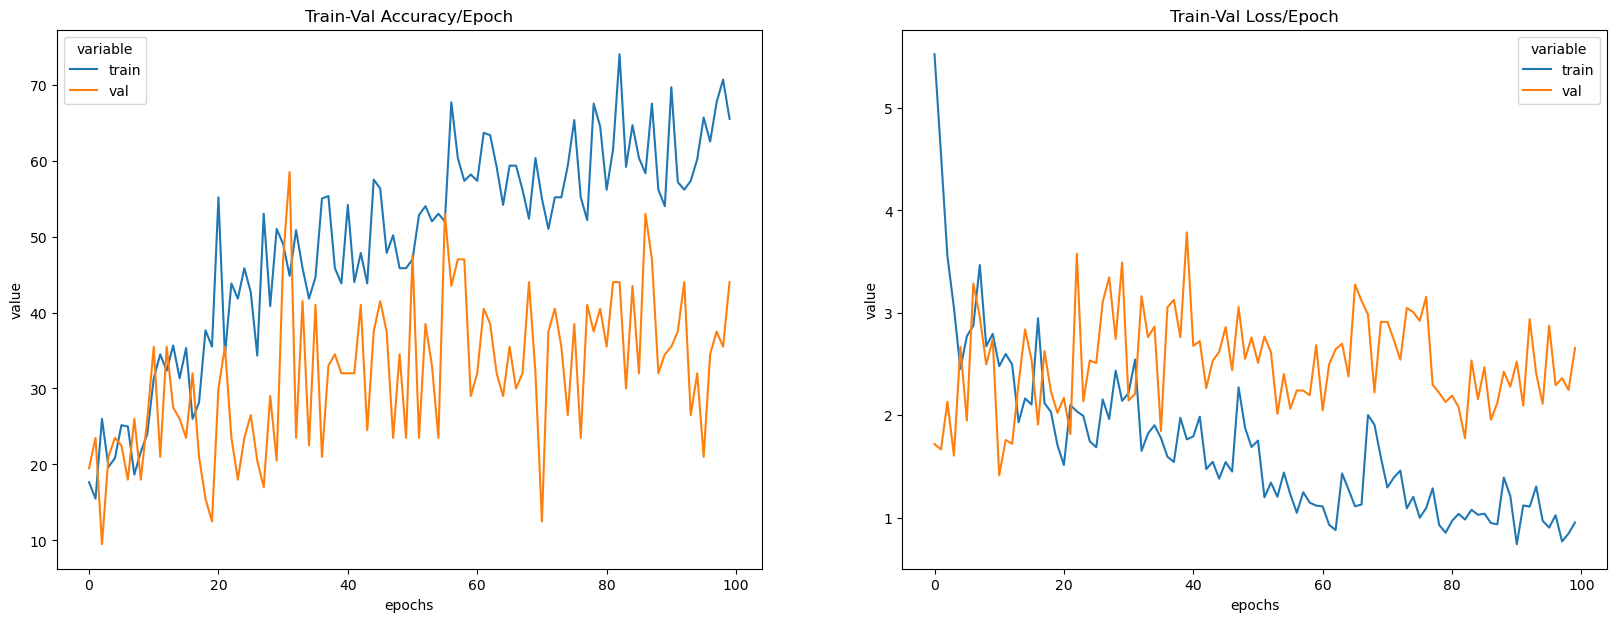

In [21]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={'index':'epochs'})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={'index':'epochs'})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

sns.lineplot(data=train_val_acc_df, x='epochs', y='value', hue='variable', ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x='epochs', y='value', hue='variable', ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [22]:
y_pred_list = []

with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim=1)
        y_pred_list.append(y_pred_tags.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

<AxesSubplot: >

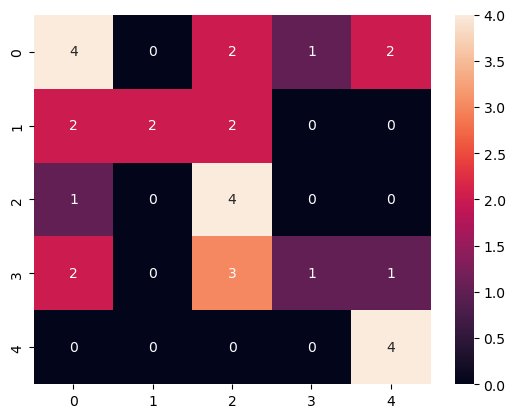

In [23]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list))

sns.heatmap(confusion_matrix_df, annot=True)

In [24]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.44      0.44      0.44         9
           1       1.00      0.33      0.50         6
           2       0.36      0.80      0.50         5
           3       0.50      0.14      0.22         7
           4       0.57      1.00      0.73         4

    accuracy                           0.48        31
   macro avg       0.58      0.54      0.48        31
weighted avg       0.57      0.48      0.45        31

